In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit,SubCircuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Logging.Logging import setup_logging
from multiprocessing import Pool
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
import random
setup_logging()

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)

In [2]:
def generate_mn_range(M_start, M_end, N_start, N_end):
    special_mn = []
    for m in range(M_start, M_end+1):
        for n in range(N_start, N_end+1):
            special_mn.append((m, n))
    return special_mn

In [3]:
M = 364
N = 91
w = 0.0025
l = 0.0025

In [4]:
def create_tandem_array(M, N, special_mn):
    circuit = Circuit('Perovskite/Silicon Tandem Equivalent Circuit')
    
    circuit.model('D1_top', 'D', IS = 8.8e-23*(w*l), N =1)
    circuit.model('D2_top', 'D', IS = 2.62e-13*(w*l), N =2)
    circuit.model('D1_bot', 'D', IS=1.3339e-14*(w*l), N =1)
    circuit.model('D2_bot', 'D', IS=6.5674e-19*(w*l), N =2)
    circuit.V('1', 'input', circuit.gnd, 0@u_V)

    for m in range(M):
        for n in range(N):
            name_prefix = f"{m:03d}{n:03d}"
            is_special = (m, n) in special_mn
            print(f"Processing m={m}, n={n}, is_special={is_special}")
            
            # Metal Sheet Resistance
            if m == 0:
                circuit.R(f'Metal_sheet_input{n:03d}', 'input', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm)
            if ( m == 1 and 0 < n < 91) or (m > 1 and  n == 45):
                circuit.R(f'Metal_sheet_v{m:03d}{n:03d}', f'q{m-1:03d}{n:03d}', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm)
                circuit.R(f'Metal_sheet_h{m:03d}{n:03d}', f'q{m:03d}{n-1:03d}', f'q{m:03d}{n:03d}', 2.13*w/l@u_mOhm)
                circuit.R(f'c_metal_{name_prefix}', f'q{m:03d}{n:03d}', f'a{m:03d}{n:03d}', 5/(w*l)@u_mOhm)            
            
                
            # ITO Sheet Resistance
            
            if m > 0:
                circuit.R(f'ITO_sheet_v{m:03d}{n:03d}', f'a{m-1:03d}{n:03d}', f'a{m:03d}{n:03d}', 55*l/w@u_Ohm)
            if n > 0:
                circuit.R(f'ITO_sheet_h{m:03d}{n:03d}', f'a{m:03d}{n-1:03d}', f'a{m:03d}{n:03d}', 55*w/l@u_Ohm)

            # RJ Sheet Resistance
            if m > 0:
                circuit.R(f'RJ_sheet_v{m:03d}{n:03d}', f'd{m-1:03d}{n:02d}', f'd{m:03d}{n:03d}', 200*l/w@u_Ohm)
            if n > 0:
                circuit.R(f'RJ_sheet_h{m:03d}{n:03d}', f'd{m:03d}{n-1:03d}', f'd{m:03d}{n:03d}', 200*w/l@u_Ohm)

            # Top Cell
            if is_special:
                circuit.R(f's_top_{name_prefix}', f'a{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 5.55/(w*l)@u_kOhm)
            else:
                circuit.R(f's_top_{name_prefix}', f'a{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 2/(w*l)@u_Ohm)
            circuit.D(f'1_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D1_top')
            circuit.D(f'2_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D2_top')
            circuit.R(f'sh_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', 5.55/(w*l)@u_kOhm)
                
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

            # Connection
            circuit.R(f'c_top_{name_prefix}', f'c{m:03d}{n:03d}', f'd{m:03d}{n:03d}', 0/(w*l)@u_mOhm)
            circuit.R(f'c_bot_{name_prefix}', f'd{m:03d}{n:03d}', f'e{m:03d}{n:03d}', 0/(w*l)@u_mOhm)

            # Bottom Cell
            circuit.R(f's_bot_{name_prefix}', f'e{m:03d}{n:03d}', f'f{m:03d}{n:03d}', 0.2/(w*l)@u_Ohm)
            circuit.D(f'1_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D1_bot')
            circuit.D(f'2_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D2_bot')
            circuit.R(f'sh_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, 12/(w*l)@u_kOhm)
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

    return circuit

In [5]:
M_start = 175
M_end = 189
N_start = 65
N_end = 79
special_mn = generate_mn_range(M_start, M_end, N_start, N_end)
circuit = create_tandem_array(M, N, special_mn)

Processing m=0, n=0, is_special=False
Processing m=0, n=1, is_special=False
Processing m=0, n=2, is_special=False
Processing m=0, n=3, is_special=False
Processing m=0, n=4, is_special=False
Processing m=0, n=5, is_special=False
Processing m=0, n=6, is_special=False
Processing m=0, n=7, is_special=False
Processing m=0, n=8, is_special=False
Processing m=0, n=9, is_special=False
Processing m=0, n=10, is_special=False
Processing m=0, n=11, is_special=False
Processing m=0, n=12, is_special=False
Processing m=0, n=13, is_special=False
Processing m=0, n=14, is_special=False
Processing m=0, n=15, is_special=False
Processing m=0, n=16, is_special=False
Processing m=0, n=17, is_special=False
Processing m=0, n=18, is_special=False
Processing m=0, n=19, is_special=False
Processing m=0, n=20, is_special=False
Processing m=0, n=21, is_special=False
Processing m=0, n=22, is_special=False
Processing m=0, n=23, is_special=False
Processing m=0, n=24, is_special=False
Processing m=0, n=25, is_special=Fa

Processing m=12, n=60, is_special=False
Processing m=12, n=61, is_special=False
Processing m=12, n=62, is_special=False
Processing m=12, n=63, is_special=False
Processing m=12, n=64, is_special=False
Processing m=12, n=65, is_special=False
Processing m=12, n=66, is_special=False
Processing m=12, n=67, is_special=False
Processing m=12, n=68, is_special=False
Processing m=12, n=69, is_special=False
Processing m=12, n=70, is_special=False
Processing m=12, n=71, is_special=False
Processing m=12, n=72, is_special=False
Processing m=12, n=73, is_special=False
Processing m=12, n=74, is_special=False
Processing m=12, n=75, is_special=False
Processing m=12, n=76, is_special=False
Processing m=12, n=77, is_special=False
Processing m=12, n=78, is_special=False
Processing m=12, n=79, is_special=False
Processing m=12, n=80, is_special=False
Processing m=12, n=81, is_special=False
Processing m=12, n=82, is_special=False
Processing m=12, n=83, is_special=False
Processing m=12, n=84, is_special=False


Processing m=24, n=1, is_special=False
Processing m=24, n=2, is_special=False
Processing m=24, n=3, is_special=False
Processing m=24, n=4, is_special=False
Processing m=24, n=5, is_special=False
Processing m=24, n=6, is_special=False
Processing m=24, n=7, is_special=False
Processing m=24, n=8, is_special=False
Processing m=24, n=9, is_special=False
Processing m=24, n=10, is_special=False
Processing m=24, n=11, is_special=False
Processing m=24, n=12, is_special=False
Processing m=24, n=13, is_special=False
Processing m=24, n=14, is_special=False
Processing m=24, n=15, is_special=False
Processing m=24, n=16, is_special=False
Processing m=24, n=17, is_special=False
Processing m=24, n=18, is_special=False
Processing m=24, n=19, is_special=False
Processing m=24, n=20, is_special=False
Processing m=24, n=21, is_special=False
Processing m=24, n=22, is_special=False
Processing m=24, n=23, is_special=False
Processing m=24, n=24, is_special=False
Processing m=24, n=25, is_special=False
Processin

Processing m=38, n=8, is_special=False
Processing m=38, n=9, is_special=False
Processing m=38, n=10, is_special=False
Processing m=38, n=11, is_special=False
Processing m=38, n=12, is_special=False
Processing m=38, n=13, is_special=False
Processing m=38, n=14, is_special=False
Processing m=38, n=15, is_special=False
Processing m=38, n=16, is_special=False
Processing m=38, n=17, is_special=False
Processing m=38, n=18, is_special=False
Processing m=38, n=19, is_special=False
Processing m=38, n=20, is_special=False
Processing m=38, n=21, is_special=False
Processing m=38, n=22, is_special=False
Processing m=38, n=23, is_special=False
Processing m=38, n=24, is_special=False
Processing m=38, n=25, is_special=False
Processing m=38, n=26, is_special=False
Processing m=38, n=27, is_special=False
Processing m=38, n=28, is_special=False
Processing m=38, n=29, is_special=False
Processing m=38, n=30, is_special=False
Processing m=38, n=31, is_special=False
Processing m=38, n=32, is_special=False
Pr

Processing m=51, n=82, is_special=False
Processing m=51, n=83, is_special=False
Processing m=51, n=84, is_special=False
Processing m=51, n=85, is_special=False
Processing m=51, n=86, is_special=False
Processing m=51, n=87, is_special=False
Processing m=51, n=88, is_special=False
Processing m=51, n=89, is_special=False
Processing m=51, n=90, is_special=False
Processing m=52, n=0, is_special=False
Processing m=52, n=1, is_special=False
Processing m=52, n=2, is_special=False
Processing m=52, n=3, is_special=False
Processing m=52, n=4, is_special=False
Processing m=52, n=5, is_special=False
Processing m=52, n=6, is_special=False
Processing m=52, n=7, is_special=False
Processing m=52, n=8, is_special=False
Processing m=52, n=9, is_special=False
Processing m=52, n=10, is_special=False
Processing m=52, n=11, is_special=False
Processing m=52, n=12, is_special=False
Processing m=52, n=13, is_special=False
Processing m=52, n=14, is_special=False
Processing m=52, n=15, is_special=False
Processing

Processing m=67, n=64, is_special=False
Processing m=67, n=65, is_special=False
Processing m=67, n=66, is_special=False
Processing m=67, n=67, is_special=False
Processing m=67, n=68, is_special=False
Processing m=67, n=69, is_special=False
Processing m=67, n=70, is_special=False
Processing m=67, n=71, is_special=False
Processing m=67, n=72, is_special=False
Processing m=67, n=73, is_special=False
Processing m=67, n=74, is_special=False
Processing m=67, n=75, is_special=False
Processing m=67, n=76, is_special=False
Processing m=67, n=77, is_special=False
Processing m=67, n=78, is_special=False
Processing m=67, n=79, is_special=False
Processing m=67, n=80, is_special=False
Processing m=67, n=81, is_special=False
Processing m=67, n=82, is_special=False
Processing m=67, n=83, is_special=False
Processing m=67, n=84, is_special=False
Processing m=67, n=85, is_special=False
Processing m=67, n=86, is_special=False
Processing m=67, n=87, is_special=False
Processing m=67, n=88, is_special=False


Processing m=85, n=44, is_special=False
Processing m=85, n=45, is_special=False
Processing m=85, n=46, is_special=False
Processing m=85, n=47, is_special=False
Processing m=85, n=48, is_special=False
Processing m=85, n=49, is_special=False
Processing m=85, n=50, is_special=False
Processing m=85, n=51, is_special=False
Processing m=85, n=52, is_special=False
Processing m=85, n=53, is_special=False
Processing m=85, n=54, is_special=False
Processing m=85, n=55, is_special=False
Processing m=85, n=56, is_special=False
Processing m=85, n=57, is_special=False
Processing m=85, n=58, is_special=False
Processing m=85, n=59, is_special=False
Processing m=85, n=60, is_special=False
Processing m=85, n=61, is_special=False
Processing m=85, n=62, is_special=False
Processing m=85, n=63, is_special=False
Processing m=85, n=64, is_special=False
Processing m=85, n=65, is_special=False
Processing m=85, n=66, is_special=False
Processing m=85, n=67, is_special=False
Processing m=85, n=68, is_special=False


Processing m=115, n=31, is_special=False
Processing m=115, n=32, is_special=False
Processing m=115, n=33, is_special=False
Processing m=115, n=34, is_special=False
Processing m=115, n=35, is_special=False
Processing m=115, n=36, is_special=False
Processing m=115, n=37, is_special=False
Processing m=115, n=38, is_special=False
Processing m=115, n=39, is_special=False
Processing m=115, n=40, is_special=False
Processing m=115, n=41, is_special=False
Processing m=115, n=42, is_special=False
Processing m=115, n=43, is_special=False
Processing m=115, n=44, is_special=False
Processing m=115, n=45, is_special=False
Processing m=115, n=46, is_special=False
Processing m=115, n=47, is_special=False
Processing m=115, n=48, is_special=False
Processing m=115, n=49, is_special=False
Processing m=115, n=50, is_special=False
Processing m=115, n=51, is_special=False
Processing m=115, n=52, is_special=False
Processing m=115, n=53, is_special=False
Processing m=115, n=54, is_special=False
Processing m=115

Processing m=131, n=3, is_special=False
Processing m=131, n=4, is_special=False
Processing m=131, n=5, is_special=False
Processing m=131, n=6, is_special=False
Processing m=131, n=7, is_special=False
Processing m=131, n=8, is_special=False
Processing m=131, n=9, is_special=False
Processing m=131, n=10, is_special=False
Processing m=131, n=11, is_special=False
Processing m=131, n=12, is_special=False
Processing m=131, n=13, is_special=False
Processing m=131, n=14, is_special=False
Processing m=131, n=15, is_special=False
Processing m=131, n=16, is_special=False
Processing m=131, n=17, is_special=False
Processing m=131, n=18, is_special=False
Processing m=131, n=19, is_special=False
Processing m=131, n=20, is_special=False
Processing m=131, n=21, is_special=False
Processing m=131, n=22, is_special=False
Processing m=131, n=23, is_special=False
Processing m=131, n=24, is_special=False
Processing m=131, n=25, is_special=False
Processing m=131, n=26, is_special=False
Processing m=131, n=27,

Processing m=141, n=88, is_special=False
Processing m=141, n=89, is_special=False
Processing m=141, n=90, is_special=False
Processing m=142, n=0, is_special=False
Processing m=142, n=1, is_special=False
Processing m=142, n=2, is_special=False
Processing m=142, n=3, is_special=False
Processing m=142, n=4, is_special=False
Processing m=142, n=5, is_special=False
Processing m=142, n=6, is_special=False
Processing m=142, n=7, is_special=False
Processing m=142, n=8, is_special=False
Processing m=142, n=9, is_special=False
Processing m=142, n=10, is_special=False
Processing m=142, n=11, is_special=False
Processing m=142, n=12, is_special=False
Processing m=142, n=13, is_special=False
Processing m=142, n=14, is_special=False
Processing m=142, n=15, is_special=False
Processing m=142, n=16, is_special=False
Processing m=142, n=17, is_special=False
Processing m=142, n=18, is_special=False
Processing m=142, n=19, is_special=False
Processing m=142, n=20, is_special=False
Processing m=142, n=21, is

Processing m=159, n=75, is_special=False
Processing m=159, n=76, is_special=False
Processing m=159, n=77, is_special=False
Processing m=159, n=78, is_special=False
Processing m=159, n=79, is_special=False
Processing m=159, n=80, is_special=False
Processing m=159, n=81, is_special=False
Processing m=159, n=82, is_special=False
Processing m=159, n=83, is_special=False
Processing m=159, n=84, is_special=False
Processing m=159, n=85, is_special=False
Processing m=159, n=86, is_special=False
Processing m=159, n=87, is_special=False
Processing m=159, n=88, is_special=False
Processing m=159, n=89, is_special=False
Processing m=159, n=90, is_special=False
Processing m=160, n=0, is_special=False
Processing m=160, n=1, is_special=False
Processing m=160, n=2, is_special=False
Processing m=160, n=3, is_special=False
Processing m=160, n=4, is_special=False
Processing m=160, n=5, is_special=False
Processing m=160, n=6, is_special=False
Processing m=160, n=7, is_special=False
Processing m=160, n=8, i

Processing m=176, n=0, is_special=False
Processing m=176, n=1, is_special=False
Processing m=176, n=2, is_special=False
Processing m=176, n=3, is_special=False
Processing m=176, n=4, is_special=False
Processing m=176, n=5, is_special=False
Processing m=176, n=6, is_special=False
Processing m=176, n=7, is_special=False
Processing m=176, n=8, is_special=False
Processing m=176, n=9, is_special=False
Processing m=176, n=10, is_special=False
Processing m=176, n=11, is_special=False
Processing m=176, n=12, is_special=False
Processing m=176, n=13, is_special=False
Processing m=176, n=14, is_special=False
Processing m=176, n=15, is_special=False
Processing m=176, n=16, is_special=False
Processing m=176, n=17, is_special=False
Processing m=176, n=18, is_special=False
Processing m=176, n=19, is_special=False
Processing m=176, n=20, is_special=False
Processing m=176, n=21, is_special=False
Processing m=176, n=22, is_special=False
Processing m=176, n=23, is_special=False
Processing m=176, n=24, is

Processing m=179, n=86, is_special=False
Processing m=179, n=87, is_special=False
Processing m=179, n=88, is_special=False
Processing m=179, n=89, is_special=False
Processing m=179, n=90, is_special=False
Processing m=180, n=0, is_special=False
Processing m=180, n=1, is_special=False
Processing m=180, n=2, is_special=False
Processing m=180, n=3, is_special=False
Processing m=180, n=4, is_special=False
Processing m=180, n=5, is_special=False
Processing m=180, n=6, is_special=False
Processing m=180, n=7, is_special=False
Processing m=180, n=8, is_special=False
Processing m=180, n=9, is_special=False
Processing m=180, n=10, is_special=False
Processing m=180, n=11, is_special=False
Processing m=180, n=12, is_special=False
Processing m=180, n=13, is_special=False
Processing m=180, n=14, is_special=False
Processing m=180, n=15, is_special=False
Processing m=180, n=16, is_special=False
Processing m=180, n=17, is_special=False
Processing m=180, n=18, is_special=False
Processing m=180, n=19, is

Processing m=196, n=50, is_special=False
Processing m=196, n=51, is_special=False
Processing m=196, n=52, is_special=False
Processing m=196, n=53, is_special=False
Processing m=196, n=54, is_special=False
Processing m=196, n=55, is_special=False
Processing m=196, n=56, is_special=False
Processing m=196, n=57, is_special=False
Processing m=196, n=58, is_special=False
Processing m=196, n=59, is_special=False
Processing m=196, n=60, is_special=False
Processing m=196, n=61, is_special=False
Processing m=196, n=62, is_special=False
Processing m=196, n=63, is_special=False
Processing m=196, n=64, is_special=False
Processing m=196, n=65, is_special=False
Processing m=196, n=66, is_special=False
Processing m=196, n=67, is_special=False
Processing m=196, n=68, is_special=False
Processing m=196, n=69, is_special=False
Processing m=196, n=70, is_special=False
Processing m=196, n=71, is_special=False
Processing m=196, n=72, is_special=False
Processing m=196, n=73, is_special=False
Processing m=196

Processing m=213, n=73, is_special=False
Processing m=213, n=74, is_special=False
Processing m=213, n=75, is_special=False
Processing m=213, n=76, is_special=False
Processing m=213, n=77, is_special=False
Processing m=213, n=78, is_special=False
Processing m=213, n=79, is_special=False
Processing m=213, n=80, is_special=False
Processing m=213, n=81, is_special=False
Processing m=213, n=82, is_special=False
Processing m=213, n=83, is_special=False
Processing m=213, n=84, is_special=False
Processing m=213, n=85, is_special=False
Processing m=213, n=86, is_special=False
Processing m=213, n=87, is_special=False
Processing m=213, n=88, is_special=False
Processing m=213, n=89, is_special=False
Processing m=213, n=90, is_special=False
Processing m=214, n=0, is_special=False
Processing m=214, n=1, is_special=False
Processing m=214, n=2, is_special=False
Processing m=214, n=3, is_special=False
Processing m=214, n=4, is_special=False
Processing m=214, n=5, is_special=False
Processing m=214, n=6,

Processing m=227, n=26, is_special=False
Processing m=227, n=27, is_special=False
Processing m=227, n=28, is_special=False
Processing m=227, n=29, is_special=False
Processing m=227, n=30, is_special=False
Processing m=227, n=31, is_special=False
Processing m=227, n=32, is_special=False
Processing m=227, n=33, is_special=False
Processing m=227, n=34, is_special=False
Processing m=227, n=35, is_special=False
Processing m=227, n=36, is_special=False
Processing m=227, n=37, is_special=False
Processing m=227, n=38, is_special=False
Processing m=227, n=39, is_special=False
Processing m=227, n=40, is_special=False
Processing m=227, n=41, is_special=False
Processing m=227, n=42, is_special=False
Processing m=227, n=43, is_special=False
Processing m=227, n=44, is_special=False
Processing m=227, n=45, is_special=False
Processing m=227, n=46, is_special=False
Processing m=227, n=47, is_special=False
Processing m=227, n=48, is_special=False
Processing m=227, n=49, is_special=False
Processing m=227

Processing m=242, n=35, is_special=False
Processing m=242, n=36, is_special=False
Processing m=242, n=37, is_special=False
Processing m=242, n=38, is_special=False
Processing m=242, n=39, is_special=False
Processing m=242, n=40, is_special=False
Processing m=242, n=41, is_special=False
Processing m=242, n=42, is_special=False
Processing m=242, n=43, is_special=False
Processing m=242, n=44, is_special=False
Processing m=242, n=45, is_special=False
Processing m=242, n=46, is_special=False
Processing m=242, n=47, is_special=False
Processing m=242, n=48, is_special=False
Processing m=242, n=49, is_special=False
Processing m=242, n=50, is_special=False
Processing m=242, n=51, is_special=False
Processing m=242, n=52, is_special=False
Processing m=242, n=53, is_special=False
Processing m=242, n=54, is_special=False
Processing m=242, n=55, is_special=False
Processing m=242, n=56, is_special=False
Processing m=242, n=57, is_special=False
Processing m=242, n=58, is_special=False
Processing m=242

Processing m=259, n=35, is_special=False
Processing m=259, n=36, is_special=False
Processing m=259, n=37, is_special=False
Processing m=259, n=38, is_special=False
Processing m=259, n=39, is_special=False
Processing m=259, n=40, is_special=False
Processing m=259, n=41, is_special=False
Processing m=259, n=42, is_special=False
Processing m=259, n=43, is_special=False
Processing m=259, n=44, is_special=False
Processing m=259, n=45, is_special=False
Processing m=259, n=46, is_special=False
Processing m=259, n=47, is_special=False
Processing m=259, n=48, is_special=False
Processing m=259, n=49, is_special=False
Processing m=259, n=50, is_special=False
Processing m=259, n=51, is_special=False
Processing m=259, n=52, is_special=False
Processing m=259, n=53, is_special=False
Processing m=259, n=54, is_special=False
Processing m=259, n=55, is_special=False
Processing m=259, n=56, is_special=False
Processing m=259, n=57, is_special=False
Processing m=259, n=58, is_special=False
Processing m=259

Processing m=275, n=63, is_special=False
Processing m=275, n=64, is_special=False
Processing m=275, n=65, is_special=False
Processing m=275, n=66, is_special=False
Processing m=275, n=67, is_special=False
Processing m=275, n=68, is_special=False
Processing m=275, n=69, is_special=False
Processing m=275, n=70, is_special=False
Processing m=275, n=71, is_special=False
Processing m=275, n=72, is_special=False
Processing m=275, n=73, is_special=False
Processing m=275, n=74, is_special=False
Processing m=275, n=75, is_special=False
Processing m=275, n=76, is_special=False
Processing m=275, n=77, is_special=False
Processing m=275, n=78, is_special=False
Processing m=275, n=79, is_special=False
Processing m=275, n=80, is_special=False
Processing m=275, n=81, is_special=False
Processing m=275, n=82, is_special=False
Processing m=275, n=83, is_special=False
Processing m=275, n=84, is_special=False
Processing m=275, n=85, is_special=False
Processing m=275, n=86, is_special=False
Processing m=275

Processing m=286, n=79, is_special=False
Processing m=286, n=80, is_special=False
Processing m=286, n=81, is_special=False
Processing m=286, n=82, is_special=False
Processing m=286, n=83, is_special=False
Processing m=286, n=84, is_special=False
Processing m=286, n=85, is_special=False
Processing m=286, n=86, is_special=False
Processing m=286, n=87, is_special=False
Processing m=286, n=88, is_special=False
Processing m=286, n=89, is_special=False
Processing m=286, n=90, is_special=False
Processing m=287, n=0, is_special=False
Processing m=287, n=1, is_special=False
Processing m=287, n=2, is_special=False
Processing m=287, n=3, is_special=False
Processing m=287, n=4, is_special=False
Processing m=287, n=5, is_special=False
Processing m=287, n=6, is_special=False
Processing m=287, n=7, is_special=False
Processing m=287, n=8, is_special=False
Processing m=287, n=9, is_special=False
Processing m=287, n=10, is_special=False
Processing m=287, n=11, is_special=False
Processing m=287, n=12, is

Processing m=311, n=78, is_special=False
Processing m=311, n=79, is_special=False
Processing m=311, n=80, is_special=False
Processing m=311, n=81, is_special=False
Processing m=311, n=82, is_special=False
Processing m=311, n=83, is_special=False
Processing m=311, n=84, is_special=False
Processing m=311, n=85, is_special=False
Processing m=311, n=86, is_special=False
Processing m=311, n=87, is_special=False
Processing m=311, n=88, is_special=False
Processing m=311, n=89, is_special=False
Processing m=311, n=90, is_special=False
Processing m=312, n=0, is_special=False
Processing m=312, n=1, is_special=False
Processing m=312, n=2, is_special=False
Processing m=312, n=3, is_special=False
Processing m=312, n=4, is_special=False
Processing m=312, n=5, is_special=False
Processing m=312, n=6, is_special=False
Processing m=312, n=7, is_special=False
Processing m=312, n=8, is_special=False
Processing m=312, n=9, is_special=False
Processing m=312, n=10, is_special=False
Processing m=312, n=11, is

Processing m=329, n=28, is_special=False
Processing m=329, n=29, is_special=False
Processing m=329, n=30, is_special=False
Processing m=329, n=31, is_special=False
Processing m=329, n=32, is_special=False
Processing m=329, n=33, is_special=False
Processing m=329, n=34, is_special=False
Processing m=329, n=35, is_special=False
Processing m=329, n=36, is_special=False
Processing m=329, n=37, is_special=False
Processing m=329, n=38, is_special=False
Processing m=329, n=39, is_special=False
Processing m=329, n=40, is_special=False
Processing m=329, n=41, is_special=False
Processing m=329, n=42, is_special=False
Processing m=329, n=43, is_special=False
Processing m=329, n=44, is_special=False
Processing m=329, n=45, is_special=False
Processing m=329, n=46, is_special=False
Processing m=329, n=47, is_special=False
Processing m=329, n=48, is_special=False
Processing m=329, n=49, is_special=False
Processing m=329, n=50, is_special=False
Processing m=329, n=51, is_special=False
Processing m=329

Processing m=345, n=59, is_special=False
Processing m=345, n=60, is_special=False
Processing m=345, n=61, is_special=False
Processing m=345, n=62, is_special=False
Processing m=345, n=63, is_special=False
Processing m=345, n=64, is_special=False
Processing m=345, n=65, is_special=False
Processing m=345, n=66, is_special=False
Processing m=345, n=67, is_special=False
Processing m=345, n=68, is_special=False
Processing m=345, n=69, is_special=False
Processing m=345, n=70, is_special=False
Processing m=345, n=71, is_special=False
Processing m=345, n=72, is_special=False
Processing m=345, n=73, is_special=False
Processing m=345, n=74, is_special=False
Processing m=345, n=75, is_special=False
Processing m=345, n=76, is_special=False
Processing m=345, n=77, is_special=False
Processing m=345, n=78, is_special=False
Processing m=345, n=79, is_special=False
Processing m=345, n=80, is_special=False
Processing m=345, n=81, is_special=False
Processing m=345, n=82, is_special=False
Processing m=345

Processing m=360, n=88, is_special=False
Processing m=360, n=89, is_special=False
Processing m=360, n=90, is_special=False
Processing m=361, n=0, is_special=False
Processing m=361, n=1, is_special=False
Processing m=361, n=2, is_special=False
Processing m=361, n=3, is_special=False
Processing m=361, n=4, is_special=False
Processing m=361, n=5, is_special=False
Processing m=361, n=6, is_special=False
Processing m=361, n=7, is_special=False
Processing m=361, n=8, is_special=False
Processing m=361, n=9, is_special=False
Processing m=361, n=10, is_special=False
Processing m=361, n=11, is_special=False
Processing m=361, n=12, is_special=False
Processing m=361, n=13, is_special=False
Processing m=361, n=14, is_special=False
Processing m=361, n=15, is_special=False
Processing m=361, n=16, is_special=False
Processing m=361, n=17, is_special=False
Processing m=361, n=18, is_special=False
Processing m=361, n=19, is_special=False
Processing m=361, n=20, is_special=False
Processing m=361, n=21, is

CPU times: total: 2h 32min 43s
Wall time: 3h 16min 54s
2023-08-30 18:43:42,413 - matplotlib.legend - legend.WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


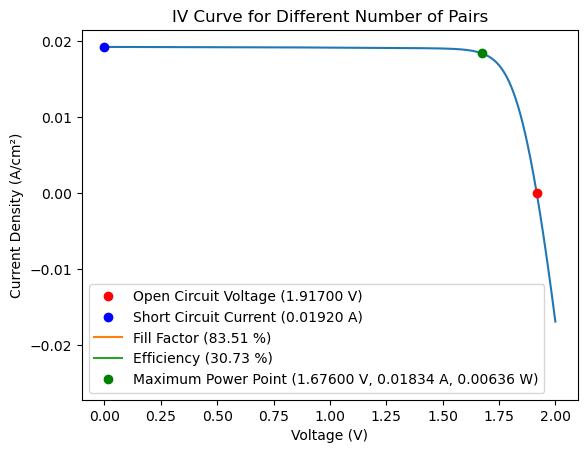

In [6]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
%time analysis = simulator.dc(V1=slice(0, 2, 0.001))
voltage = analysis.nodes['input'].as_ndarray()  # analysis: a dictionary of measured values from nodes and branches
current = analysis.branches['v1'].as_ndarray()  # as_ndarray: converts measured values from a specific node or branch into a numpy array
normalized_current = current / (w * l * M *N)

# Calculate open circuit voltage
v_oc_index = np.argmin(np.abs(normalized_current))  # abs: function that returns the absolute value of a given number
v_oc = voltage[v_oc_index]  # argmin: returns the index of the minimum element in the numpy array

# Calculate short circuit current
i_sc_index = np.argmin(np.abs(voltage))
i_sc = normalized_current[i_sc_index]

# Calculate Maximum Power Point
power = voltage * current
mpp_index = np.argmax(power)
v_mpp = voltage[mpp_index]
i_mpp = normalized_current[mpp_index]
max_power = power[mpp_index]
efficiency = (max_power/(0.1*w*l*M*N))*100

# Calculate Fill Factor
fill_factor = (v_mpp * i_mpp) / (v_oc * i_sc)

plt.plot(voltage, normalized_current)

plt.legend()
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/cm²)')
plt.title('IV Curve for Different Number of Pairs')

# 오픈 회로 전압과 단락 전류 표시
plt.plot(v_oc, 0, 'ro', label=f'Open Circuit Voltage ({v_oc:.5f} V)')
plt.plot(0, i_sc, 'bo', label=f'Short Circuit Current ({i_sc:.5f} A)')
plt.plot(0, -0.025, label=f'Fill Factor ({fill_factor*100:.2f} %)')
plt.plot(0, -0.02, label=f'Efficiency ({efficiency:.2f} %)')
# 최대 전력 지점 표시
plt.plot(v_mpp, i_mpp, 'go', label=f'Maximum Power Point ({v_mpp:.5f} V, {i_mpp:.5f} A, {max_power:.5f} W)')

plt.legend()

plt.show()